In [1]:
import numpy as np
import matplotlib.pylab as plt
import pickle
import json
import new_files
import pandas as pd
import nibabel as nb
from os import sep
from copy import deepcopy
from scipy.interpolate import interp1d
from matplotlib import colors
import elephant
import neo
import quantities as pq
import matplotlib.pylab as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import colors
import trimesh
import open3d as o3d
from ffntr import fooofinator
from tools import compute_rel_power, get_crossover, detect_crossing_points, data_to_rgb
from sklearn.preprocessing import minmax_scale

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [96]:
def plot_new_basic_results(
    info, vertex_no, cl_vx, signal, times, CSD_res, cluster, 
    epoch_types, epoch_type, freqs, layer_power, crossover,
    relative_power, smooth_power):
    
    cm = plt.colormaps["rainbow"]
    cm_l = cm(np.linspace(0,1, num=info["layers"]))[:,:3]

    f, ax = plt.subplots(2,3, figsize=(9,6))

    plot_spaced_signal(signal, times, ax=ax[0,0])
    cst_det = plot_csd(
        CSD_res, cluster, info["big_brain_layers_path"], 
        epoch_types[epoch_type][0], ax=ax[0,1], cb=False,
        return_details=True
    )
    ax[0,2].axis("off")
    plt.colorbar(cst_det[1], ax=ax[0,2], label="CSD Z-score")

    for ix in range(info["layers"]):
        ax[1,0].plot(freqs, layer_power[ix], c=cm_l[ix], lw=1.5)
        ax[1,0].set_title("PSD per layer - offset")
        ax[1,0].axvline(7, lw=0.5, c="black")
        ax[1,0].axvline(30, lw=0.5, c="black")
        ax[1,0].axvline(50, lw=0.5, c="black")
    

    ax[1,1].set_title("Relative PSD per layer")
    layer_deets = plot_csd(
        smooth_power, cluster,
        info["big_brain_layers_path"], 
        freqs, ax=ax[1,1], cmap="YlGnBu",
        vmin_vmax="norm", cb=False, return_details=True
    )
    
    yl=ax[1,1].get_ylim()
    ax[1,1].plot([7,7],yl,':', lw=1.5, c="white")
    ax[1,1].plot([30,30],yl,':', lw=1.5, c="white")
    ax[1,1].plot([50,50],yl,':', lw=1.5, c="white")
    ax[1,1].axhline(crossover/smooth_power.shape[0], linestyle=(0, (5,5)), c="red", lw=1)


    ab_idx = np.where((freqs >= 7) & (freqs <= 30))[0]
    g_idx = np.where((freqs >= 50) & (freqs <= 125))[0]

    ab_pow = np.mean(smooth_power[:, ab_idx][::-1,:], axis=1)
    g_pow = np.mean(smooth_power[:, g_idx][::-1,:], axis=1)

    ax[1,2].plot(ab_pow,np.linspace(0,1,smooth_power.shape[0]),label='alpha-beta', c="green")
    ax[1,2].plot(g_pow,np.linspace(0,1,smooth_power.shape[0]),label='gamma', c="blue")

    ax[1,2].set_ylim(1, 0)
    ax[1,2].set_yticks(np.linspace(0,1, num=11))
    ax[1,2].set_yticklabels(np.arange(1,12));
    for th, lab in layer_deets[0]:
        ax[1,2].axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
        ax[1,2].annotate(lab,[0.01, th-0.01],size=15)
    ax[1,2].axhline(crossover/smooth_power.shape[0], linestyle=(0, (5,5)), c="red", lw=1, label="Crossover")
    handles = [
        Line2D([], [], color="blue", label="Gamma"),
        Line2D([], [], color="green", label="Alpha-beta"),
        Line2D([], [], color="red", linestyle="dashed", label="Crossover")
    ]
    ax[1,2].legend(handles=handles, loc=8, frameon=True, fontsize="xx-small")
    ax[1,2].set_xlabel("Relative Power")
    
    ax[0,0].set_title("Source Localized Signal")
    ax[0,1].set_title("Second spatial\nderivative of the signal")
    ax[1,2].set_title("Crossover")
    ax[0,0].set_xlabel("Time [s]")
    ax[0,1].set_xlabel("Time [s]")
    
    cl_rel_amp = minmax_scale(metric[cluster])
    title = "REL AMP CL (0-1): {} | atlas: {}".format(
        np.round(cl_rel_amp[vertex_no], 3), atlas_labels[cl_vx]
    )
    f.suptitle(title)
    plt.tight_layout()

In [97]:
# def plot_basic_results(
#     info, vertex_no, cl_vx, signal, times, CSD_res, 
#     cluster, epoch_types, epoch_type, freqs, layer_power, 
#     layer_periodic, layer_aperiodic, relative_total, 
#     relative_periodic, relative_aperiodic, smooth_rel_total, 
#     smooth_rel_per, smooth_rel_aper, crossover, exp_smooth, off_smooth):
    
#     cm = plt.colormaps["rainbow"]
#     cm_l = cm(np.linspace(0,1, num=info["layers"]))[:,:3]

#     f, ax = plt.subplots(3,3, figsize=(10,9))

#     plot_spaced_signal(signal, times, ax=ax[0,0])
#     cst_det = plot_csd(
#         CSD_res, cluster, info["big_brain_layers_path"], 
#         epoch_types[epoch_type][0], ax=ax[0,1], cb=False,
#         return_details=True
#     )
#     plt.colorbar(cst_det[1], ax=ax[0,2], label="CSD Z-score")

#     for ix in range(info["layers"]):
#         ax[1,0].plot(freqs, layer_power[ix], c=cm_l[ix], lw=1.5)
#         ax[1,0].set_title("PSD per layer")
#         ax[1,0].axvline(7, lw=0.5, c="black")
#         ax[1,0].axvline(30, lw=0.5, c="black")
#         ax[1,0].axvline(50, lw=0.5, c="black")
#         ax[1,1].plot(freqs, layer_periodic[ix], c=cm_l[ix], lw=1.5)
#         ax[1,1].set_title("Periodic power")
#         ax[1,1].axvline(7, lw=0.5, c="black")
#         ax[1,1].axvline(30, lw=0.5, c="black")
#         ax[1,1].axvline(50, lw=0.5, c="black")
#         ax[1,2].plot(freqs, layer_aperiodic[ix], c=cm_l[ix], lw=1.5)
#         ax[1,2].set_title("Aperiodic power")
#         ax[1,2].axvline(7, lw=0.5, c="black")
#         ax[1,2].axvline(30, lw=0.5, c="black")
#         ax[1,2].axvline(50, lw=0.5, c="black")

#     ax[2,0].set_title("Relative PSD per layer")
#     plot_csd(
#         smooth_rel_total, cluster,
#         info["big_brain_layers_path"], 
#         freqs, ax=ax[2,0], cmap="YlGnBu",
#         vmin_vmax="norm", cb=False
#     )

#     ax[2,1].set_title("Relative periodic power")
#     plot_csd(
#         smooth_rel_per, cluster,
#         info["big_brain_layers_path"], 
#         freqs, ax=ax[2,1], cmap="YlGnBu",
#         vmin_vmax="norm", cb=False
#     )

#     ax[2,2].set_title("Relative aperiodic power")
#     layer_deets = plot_csd(
#         smooth_rel_aper, cluster,
#         info["big_brain_layers_path"], 
#         freqs, ax=ax[2,2], cmap="YlGnBu",
#         vmin_vmax="norm", cb=False, return_details=True
#     )

#     yl=ax[2,0].get_ylim()
#     ax[2,0].plot([7,7],yl,':', lw=0.5, c="black")
#     ax[2,0].plot([30,30],yl,':', lw=0.5, c="black")
#     ax[2,0].plot([50,50],yl,':', lw=0.5, c="black")
#     ax[2,0].axhline(crossover/smooth_rel_total.shape[0], linestyle=(0, (5,5)), c="red", lw=1)
#     ax[2,1].set_yticks(np.linspace(0,1, num=info["layers"]))
#     ax[2,1].set_yticklabels(np.arange(1,12))
#     ax[2,1].plot([7,7],yl,':', lw=0.5, c="black")
#     ax[2,1].plot([30,30],yl,':', lw=0.5, c="black")
#     ax[2,1].plot([50,50],yl,':', lw=0.5, c="black")
#     ax[2,1].axhline(crossover/smooth_rel_total.shape[0], linestyle=(0, (5,5)), c="red", lw=1)
#     ax[2,2].set_yticks(np.linspace(0,1, num=info["layers"]))
#     ax[2,2].set_yticklabels(np.arange(1,12));
#     ax[2,2].plot([7,7],yl,':', lw=0.5, c="black")
#     ax[2,2].plot([30,30],yl,':', lw=0.5, c="black")
#     ax[2,2].plot([50,50],yl,':', lw=0.5, c="black")
#     ax[2,2].axhline(crossover/smooth_rel_total.shape[0], linestyle=(0, (5,5)), c="red", lw=1)

#     ab_idx = np.where((freqs >= 7) & (freqs <= 30))[0]
#     g_idx = np.where((freqs >= 50) & (freqs <= 125))[0]

#     ab_rel_pow = np.mean(smooth_rel_per[:, ab_idx], axis=1)
#     g_rel_pow = np.mean(smooth_rel_aper[:, g_idx], axis=1)

#     ax[0,2].plot(ab_rel_pow,np.linspace(0,1,smooth_rel_total.shape[0]),label='Periodic apha-beta', c="green")
#     ax[0,2].plot(g_rel_pow,np.linspace(0,1,smooth_rel_total.shape[0]),label='Aperiodic gamma', c="blue")
#     ax[0,2].plot(exp_smooth, np.linspace(0, 1, smooth_rel_total.shape[0]), label='exponent', c="purple")
#     ax[0,2].plot(off_smooth, np.linspace(0, 1, smooth_rel_total.shape[0]), label='offset', c="orange")

#     ax[0,2].set_ylim(1, 0)
#     ax[0,2].set_yticks(np.linspace(0,1, num=11))
#     ax[0,2].set_yticklabels(np.arange(1,12));
#     for th, lab in layer_deets[0]:
#         ax[0,2].axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
#         ax[0,2].annotate(lab,[0.01, th-0.01],size=15)
#     ax[0,2].axhline(crossover/smooth_rel_total.shape[0], linestyle=(0, (5,5)), c="red", lw=1, label="Crossover")
#     handles = [
#         Line2D([], [], color="blue", label="Aperiodic Gamma"),
#         Line2D([], [], color="green", label="Periodic Alpha-beta"),
#         Line2D([], [], color="purple", label="Minmax Exponent"),
#         Line2D([], [], color="orange", label="Minmax Offset"),
#         Line2D([], [], color="red", linestyle="dashed", label="Crossover")
#     ]
#     ax[0,2].legend(handles=handles, loc=8, frameon=True, fontsize="xx-small")

#     ax[0,0].set_title("Source Localized Signal")
#     ax[0,1].set_title("Second spatial\nderivative of the signal")
#     ax[0,2].set_title("Crossover")
#     ax[0,0].set_xlabel("Time [s]")
#     ax[0,1].set_xlabel("Time [s]")
#     ax[0,2].set_xlabel("Relative Power")
#     cl_rel_amp = minmax_scale(metric[cluster])
#     title = "REL AMP CL (0-1): {} | atlas: {}".format(
#         np.round(cl_rel_amp[vertex_no], 3), atlas_labels[cl_vx]
#     )
#     f.suptitle(title)
#     plt.tight_layout()

In [98]:
def custom_draw_geometry(mesh, filename="render.png", visible=True, wh=[960, 960], save=True):
    vis = o3d.visualization.Visualizer()
    vis.create_window(width=wh[0], height=wh[1], visible=visible)
    if isinstance(mesh, list):
        for i in mesh:
            vis.add_geometry(i)
    else:
        vis.add_geometry(mesh)
    vis.get_render_option().mesh_show_back_face=True
    vis.get_render_option().light_on=True
    vis.run()
    if save:
        vis.capture_screen_image(filename, do_render=True)
    vis.destroy_window()


def csd_calc(signal, thickness, sfreq):
    """
    signal - contact x time
    thickness - overall in mm
    sampling rate - in Hz
    """
    sig = neo.core.AnalogSignal(
        signal.T, units="T", sampling_rate=sfreq*pq.Hz
    )
    th = pq.Quantity(np.linspace(0, thickness, num=11).reshape(-1,1)) * pq.mm
    csd_est = elephant.current_source_density.estimate_csd(
        sig, th,
        method = "StandardCSD"
    )
    return csd_est.as_array().T


def csd_smooth(csd, layers=11, kind="cubic"):
    layers, time = csd.shape
    smoothed = []
    x = np.linspace(0, 1, num=layers)
    xs = np.linspace(0, 1, num=500)
    for t in range(time):
        fx = interp1d(x, csd[:, t], kind=kind)
        ys = fx(xs)
        smoothed.append(ys)
    smoothed = np.array(smoothed).T
    return smoothed


def plot_spaced_signal(signal, times, ax):
    v_contacts = signal.shape[0]
    cm = plt.colormaps["rainbow"]
    cm_l = cm(np.linspace(0,1, num=v_contacts))[:,:3]
    max_amp = np.abs(signal).max()
    max_amp = max_amp + max_amp*0.05
    spacing = np.linspace(0, max_amp * v_contacts, num=v_contacts)
    vis_signal = signal + spacing.reshape(-1,1)
    for ix, vs in enumerate(vis_signal):
        ax.plot(times, vs, lw=1, c=cm_l[ix])
    ax.set_yticks(spacing)
    ax.set_yticklabels(np.arange(1,v_contacts+1)[::-1])
    ax.set_ylim(spacing[0] - max_amp, spacing[-1] + max_amp)


def plot_csd(smooth_csd, list_ROI_vertices, bb_path, times, ax, cb=True, cmap="RdBu_r", vmin_vmax=None, return_details=False):
    layer_labels = ["I", "II", "III", "IV", "V", "VI"]
    with open(bb_path, "r") as fp:
        bb = json.load(fp)
    bb = [np.array(bb[i])[list_ROI_vertices] for i in bb.keys()]
    bb_mean = [np.mean(i) for i in bb]
    bb_std = [np.std(i) for i in bb]
    max_smooth = np.max(np.abs(smooth_csd))
    if vmin_vmax == None:
        divnorm = colors.TwoSlopeNorm(vmin=-max_smooth, vcenter=0, vmax=max_smooth)
    elif vmin_vmax == "norm":
        divnorm = colors.Normalize()
    else:
        divnorm = colors.TwoSlopeNorm(vmin=vmin_vmax[0], vcenter=0, vmax=vmin_vmax[1])
    extent = [times[0], times[-1], 1, 0]
    csd_imshow = ax.imshow(
        smooth_csd[::-1,:], norm=divnorm, origin="lower",
        aspect="auto", extent=extent,
        cmap=cmap, interpolation="none"
    )
    ax.set_ylim(1,0)
    ax.set_yticks(np.linspace(0,1, num=info["layers"]))
    ax.set_yticklabels(np.arange(1,12))
    layers_params = []
    for l_ix, th in enumerate(np.cumsum(bb_mean)):
        ax.axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
        # ax.axhspan(th-bb_std[l_ix], th+bb_std[l_ix], alpha=0.05, color="black", lw=0)
        ax.annotate(layer_labels[l_ix],[times[0]+0.06, th-0.01], size=15, ha='left')
        layers_params.append([th, layer_labels[l_ix]])
    if cb:
        plt.colorbar(csd_imshow, ax=ax)
    plt.tight_layout()
    if return_details:
        return layers_params, csd_imshow

In [5]:
epoch_types = {
    "visual": [np.linspace(-0.2, 0.8, num=601), [0.0, 0.2], -0.01],
    "motor": [np.linspace(-0.5, 0.5, num=601), [-0.2, 0.2], -0.2]
}

crop_info = {
    "visual": (-0.2, 0.8),
    "motor": (-0.5, 0.5)
}

flims = [0.1,125] # freq limits for psd

In [6]:
dir_search = new_files.Files()
img_path = "/scratch/poster_visualisations"
all_results = dir_search.get_files(img_path,"*.pickle", strings=["raw_preproc"])
all_results.sort()

In [39]:
pickle_file = all_results[1]
print(pickle_file)
epoch_type = [i for i in epoch_types.keys() if i in pickle_file.split(sep)[-1]][0]
with (open(pickle_file, "rb")) as file:
    data = pickle.load(file)

with open(data["json"]) as pipeline_file:
    info = json.load(pipeline_file)

metric = data["log_variance"]
atlas_labels = data["atlas_labels"]
clusters = data["clusters"]
results_vx_dict = data["vertex_mean_signal_psd"]
cortical_thickness = np.load(info["cortical_thickness_path"])
times = epoch_types[epoch_type][0]

/scratch/poster_visualisations/raw_preproc_autoreject-sub-001-ses-01-001-visual-epo.pickle


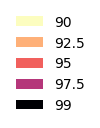

In [40]:
# METRIC VISUALISATION
prc_range = [90, 92.5, 95, 97.5, 99]
cm = plt.colormaps["magma_r"]
col_val = np.linspace(0, 0.5,num=len(prc_range)-1)
col_val = np.append(col_val, 1)
label_colours = cm(col_val)[:,:3]

legend_items = []
for ix, lab in enumerate(prc_range):
    p = Patch(
        facecolor=label_colours[ix],
        label="{}".format(lab)
    )
    legend_items.append(p)
f, ax = plt.subplots(figsize=(1,1))
ax.legend(handles=legend_items, loc="center", frameon=False)
ax.axis("off");

In [41]:
# METRIC VISUALISATION
brain = nb.load(info["pial_ds_nodeep_inflated"])
vertices, faces = brain.agg_data()
mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False, validate=False)
mesh = mesh.as_open3d
mesh.compute_vertex_normals(normalized=True)
gray = np.array([0.5, 0.5, 0.5])
colours = np.repeat(gray.reshape(1,-1), vertices.shape[0], axis=0)

for ix, pr in enumerate(prc_range):
    map_perc = data["log_variance"] >= np.percentile(data["log_variance"], pr)
    colours[map_perc] = label_colours[ix]

mesh.vertex_colors = o3d.utility.Vector3dVector(colours)
shapes = [mesh]
custom_draw_geometry(shapes, save=False)

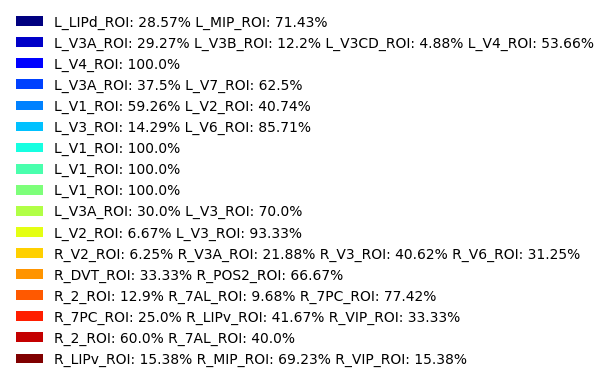

In [45]:
# CLUSTERS VISUALISATION
cluster_no = len(clusters)
cm = plt.colormaps["jet"]
col_val = np.linspace(0,1,num=cluster_no)
label_colours = cm(col_val)[:,:3]
legend_items = []

cluster_desc = {}
for ix, lab in enumerate(col_val):
    labs, counts = np.unique(atlas_labels[clusters[ix]], return_counts=True)
    cluster_desc[ix] = []
    for ixx, lab in enumerate(labs):
        la = "{}: {}% ".format(lab, np.round(counts[ixx]/np.sum(counts)*100, 2))
        cluster_desc[ix].append(la)
    
    p = Patch(
        facecolor=label_colours[ix],
        label="".join(cluster_desc[ix])[:-1]
    )
    legend_items.append(p)
f, ax = plt.subplots(figsize=(3,2))
ax.legend(handles=legend_items, loc="center", frameon=False)
ax.axis("off");

In [46]:
# CLUSTERS VISUALISATION
mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False, validate=False)
mesh = mesh.as_open3d
mesh.compute_vertex_normals(normalized=True)
gray = np.array([0.5, 0.5, 0.5])
blue = np.array([0, 0.75, 1])
colours = np.repeat(gray.reshape(1,-1), vertices.shape[0], axis=0)

for ix, pp in enumerate(clusters):
    colours[pp] = label_colours[ix]

mesh.vertex_colors = o3d.utility.Vector3dVector(colours)
shapes = [mesh]
custom_draw_geometry(shapes, save=False)

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


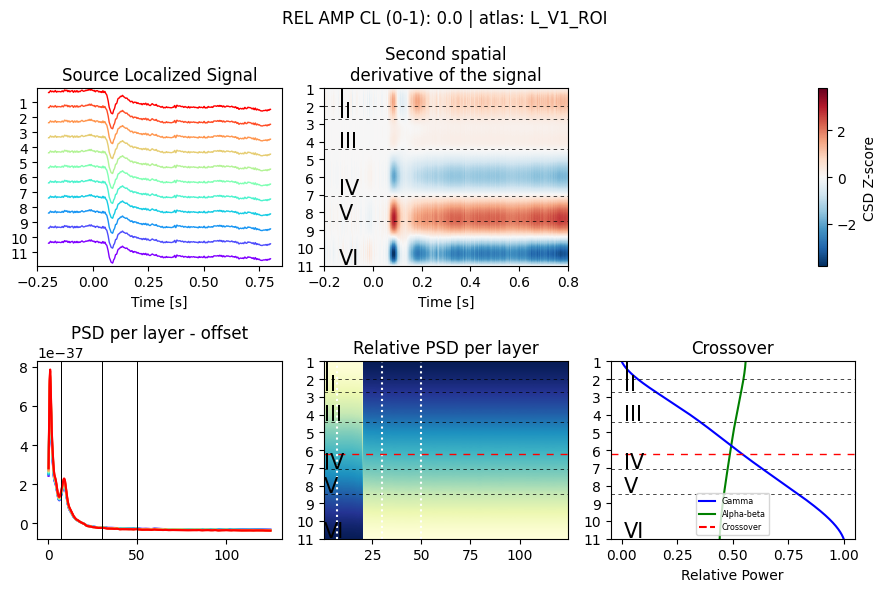

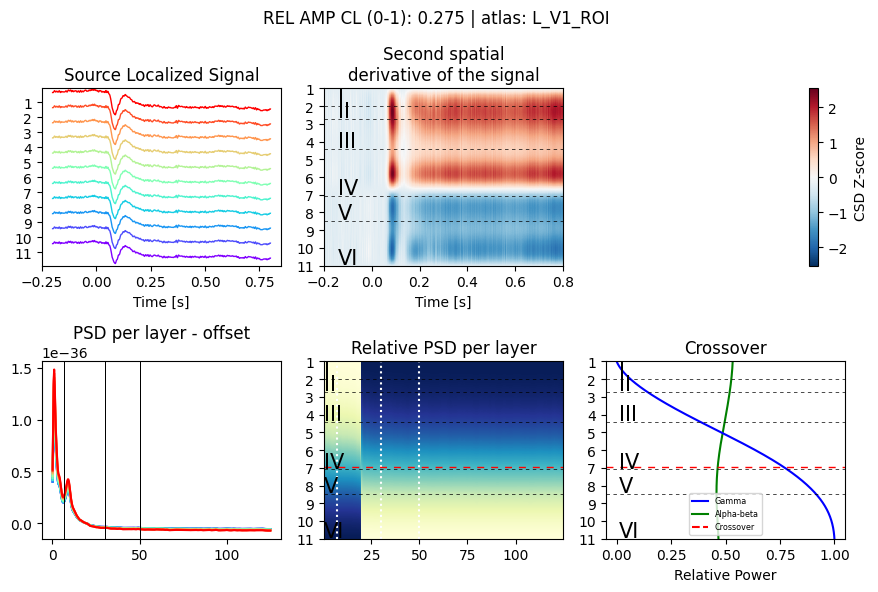

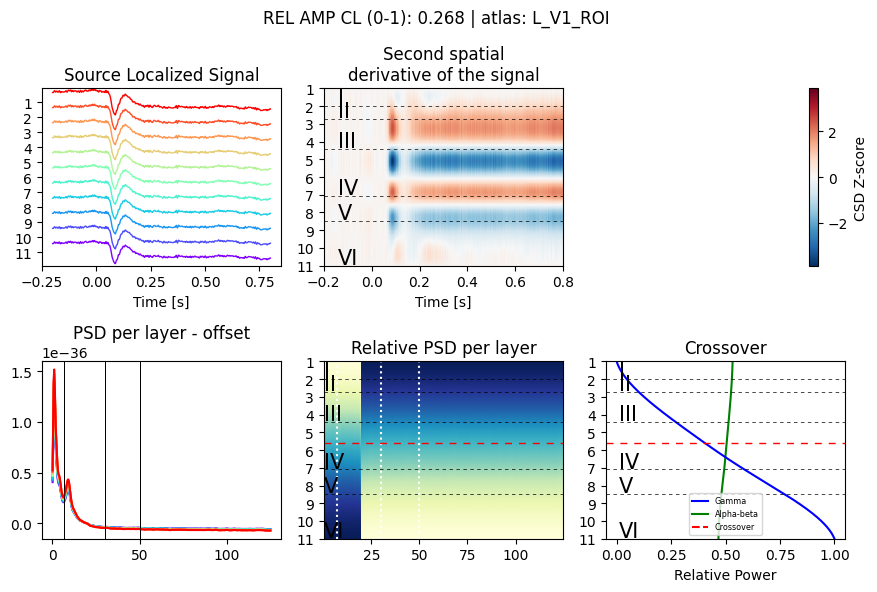

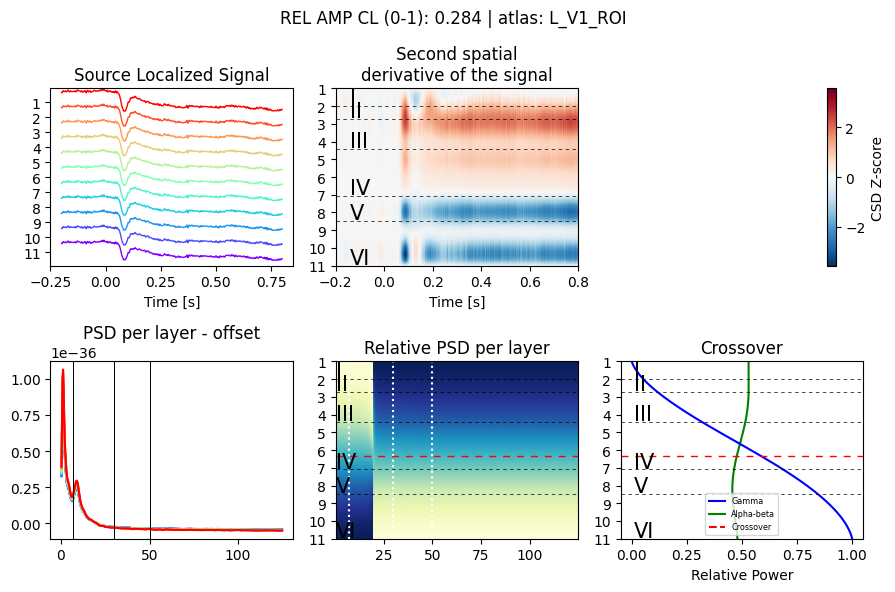

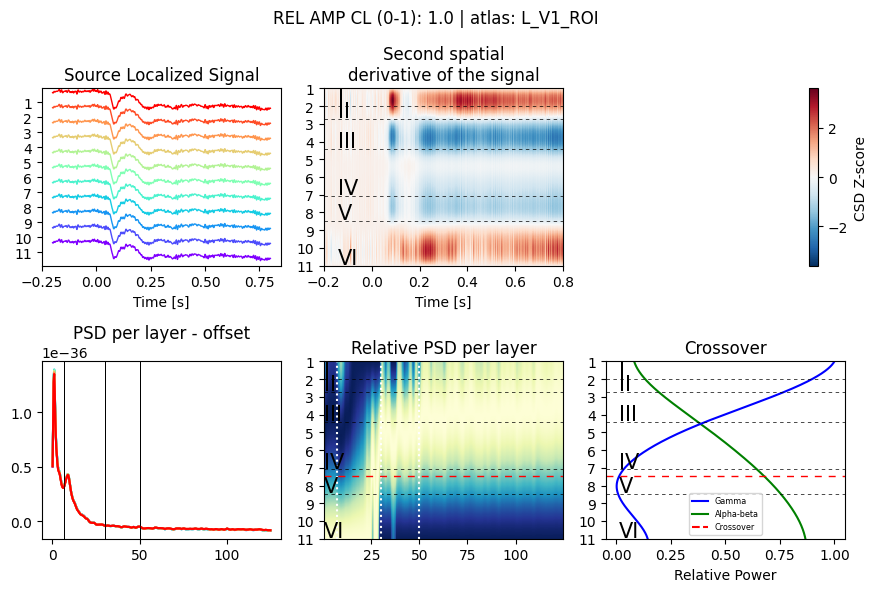

In [99]:
cluster_no = 8
cluster = clusters[cluster_no]

csd_per_vertex = {}
for vertex_no, cl_vx in enumerate(cluster):
    signal = results_vx_dict[(cl_vx, "signal")]
    CSD_res = csd_calc(signal, cortical_thickness[cl_vx], 600.0);
    CSD_res[0] = np.zeros(CSD_res[0].shape)
    CSD_res[-1] = np.zeros(CSD_res[0].shape)
    CSD_res = csd_smooth(CSD_res)
    baseline_lim = epoch_types[epoch_type][2]
    baseline = np.mean(CSD_res[:, np.where(epoch_types[epoch_type][0] < baseline_lim)], axis=2)
    CSD_res = CSD_res - baseline
    CSD_res = (CSD_res - CSD_res.mean()) / CSD_res.std()
    freqs = results_vx_dict["freqs"]
    layer_power = results_vx_dict[(cl_vx, "mean_psd")]
    layer_power = layer_power - np.mean(layer_power, axis=1).reshape(-1, 1)
    relative_power = compute_rel_power(layer_power, freqs)
    smooth_power = csd_smooth(relative_power)
    
    try:
        crossover = get_crossover(freqs, smooth_power, smooth_power)
    except:
        crossover = 0

    plot_new_basic_results(
        info, vertex_no, cl_vx, signal, times, CSD_res, cluster, 
        epoch_types, epoch_type, freqs, layer_power, crossover,
        relative_power, smooth_power
    )
    
    csd_per_vertex[cl_vx] = CSD_res

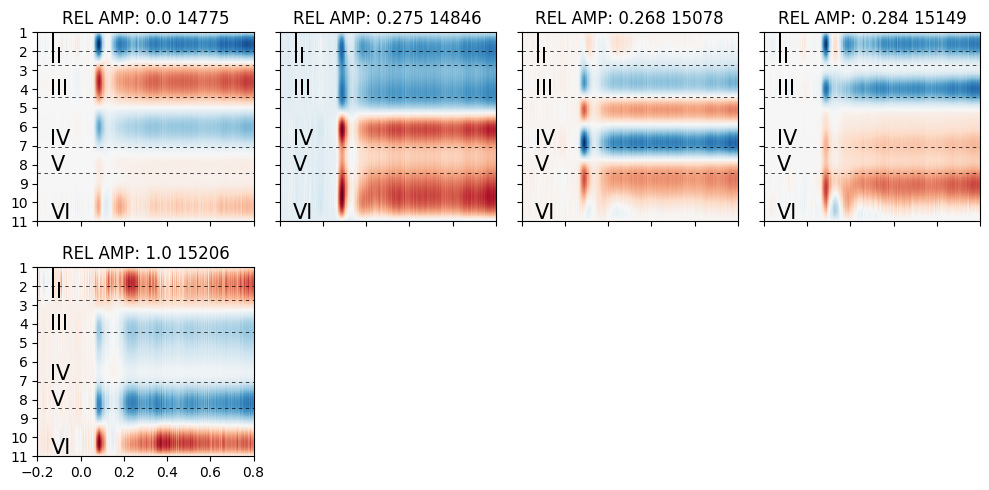

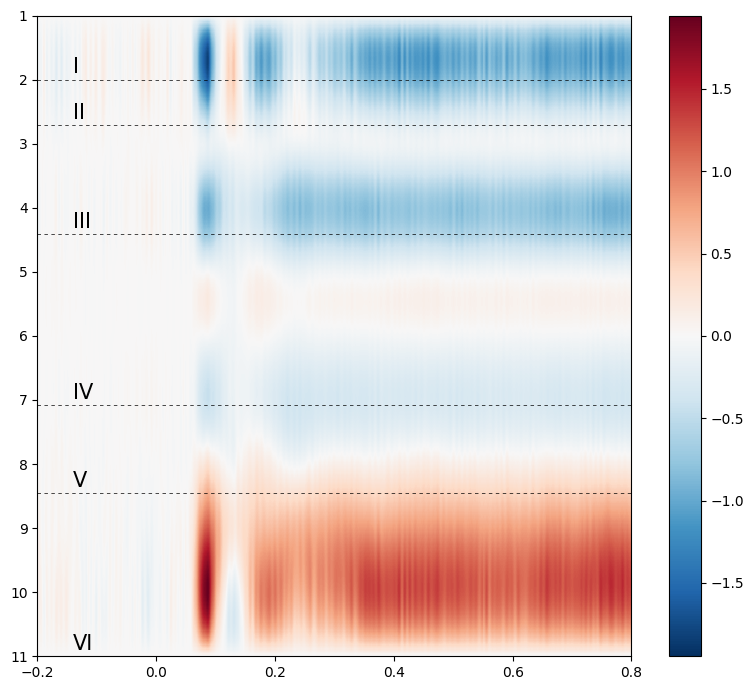

In [51]:
vxlist = list(csd_per_vertex.keys())
columns = 4
rows = np.ceil(len(vxlist) / columns).astype(int)

f, axes = plt.subplots(rows, columns, figsize=(columns*2.5, rows*2.5), sharex=True, sharey=True)
axes = axes.flatten()
cl_rel_amp = minmax_scale(metric[cluster])

for ix, ax in enumerate(axes):
    try:
        vert = vxlist[ix]
        plot_csd(
            csd_per_vertex.get(vert), cluster,
            info["big_brain_layers_path"], 
            epoch_types[epoch_type][0], ax=ax, cmap="RdBu_r",
            cb=False
        )
        ax.set_title("REL AMP: {} {}".format(np.round(cl_rel_amp[ix], 3), vert))
    except:
        vert = False
        ax.axis("off")
plt.tight_layout()


f, ax = plt.subplots(1,1, figsize=(8,7))
average_csd = np.average(list(csd_per_vertex.values()), axis=0)
plot_csd(
    average_csd, cluster,
    info["big_brain_layers_path"], 
    epoch_types[epoch_type][0], ax=ax, cmap="RdBu_r",
    cb=True
)

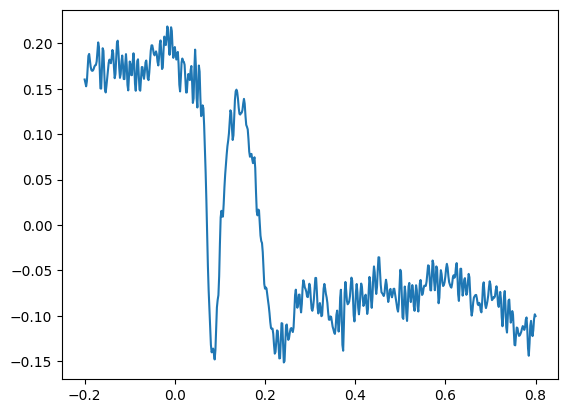

In [58]:
plt.plot(epoch_types[epoch_type][0], np.mean(csd_per_vertex.get(15206), axis=0))

In [71]:
def gaussian(x, mu, sigma, amp):
    g = 1./(np.sqrt(2.*np.pi)*sigma)*np.exp(-np.power((x - mu)/sigma, 2.)/2)
    g = g / np.max(g)
    g = g * amp
    return g

In [73]:
np.vstack([ for a in np.linspace(0.5, 1, num=11)])

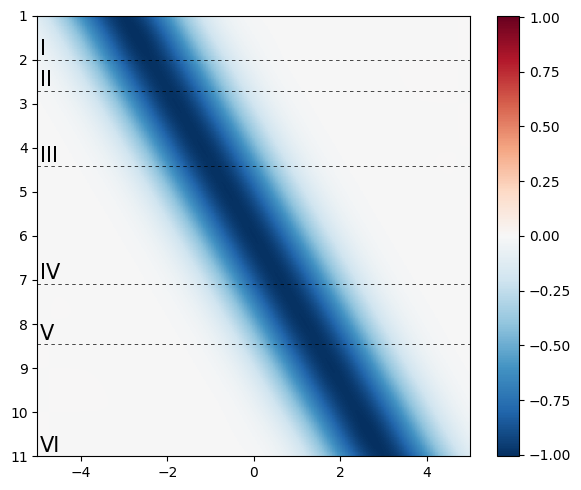

In [95]:
def plot_csd_edit(smooth_csd, list_ROI_vertices, bb_path, times, ax, cb=True, cmap="RdBu_r", vmin_vmax=None, return_details=False):
    layer_labels = ["I", "II", "III", "IV", "V", "VI"]
    with open(bb_path, "r") as fp:
        bb = json.load(fp)
    bb = [np.array(bb[i])[list_ROI_vertices] for i in bb.keys()]
    bb_mean = [np.mean(i) for i in bb]
    bb_std = [np.std(i) for i in bb]
    max_smooth = np.max(np.abs(smooth_csd))
    if vmin_vmax == None:
        divnorm = colors.TwoSlopeNorm(vmin=-max_smooth, vcenter=0, vmax=max_smooth)
    elif vmin_vmax == "norm":
        divnorm = colors.Normalize()
    else:
        divnorm = colors.TwoSlopeNorm(vmin=vmin_vmax[0], vcenter=0, vmax=vmin_vmax[1])
    extent = [times[0], times[-1], 1, 0]
    csd_imshow = ax.imshow(
        smooth_csd[::-1,:], norm=divnorm, origin="lower",
        aspect="auto", extent=extent,
        cmap=cmap, interpolation="none"
    )
    ax.set_ylim(1,0)
    ax.set_yticks(np.linspace(0,1, num=info["layers"]))
    ax.set_yticklabels(np.arange(1,12))
    layers_params = []
    for l_ix, th in enumerate(np.cumsum(bb_mean)):
        ax.axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
        # ax.axhspan(th-bb_std[l_ix], th+bb_std[l_ix], alpha=0.05, color="black", lw=0)
        ax.annotate(layer_labels[l_ix],[times[0]+0.06, th-0.01], size=15, ha='left')
        layers_params.append([th, layer_labels[l_ix]])
    if cb:
        plt.colorbar(csd_imshow, ax=ax)
    plt.tight_layout()
    if return_details:
        return layers_params, csd_imshow

x = np.linspace(-5,5, 601)
layer = np.vstack([gaussian(x, a, 1, -1) for a in np.linspace(-3, 3, num=11)])
f, ax = plt.subplots(1,1, figsize=(6,5))
plot_csd_edit(
    csd_smooth(layer), cluster,
    info["big_brain_layers_path"], 
    x, ax=ax, cmap="RdBu_r",
    cb=True
)

array([11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1])